In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

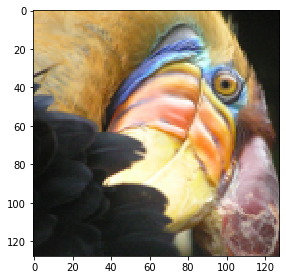

In [30]:
from skimage import io

# cast to float, you need to do this otherwise the color would be weird after clustring
pic = io.imread('data/bird_small.png') / 255.
io.imshow(pic)

In [31]:
pic.shape

(128, 128, 3)

In [32]:
# serialize data
data = pic.reshape(128*128, 3)

In [33]:
def k_means(data, k, epoch=100, n_init=10):
    """do multiple random init and pick the best one to return
    Args:
        data (pd.DataFrame)
    Returns:
        (C, centroids, least_cost)
    """

    tries = np.array([_k_means_iter(data, k, epoch) for _ in range(n_init)])

    least_cost_idx = np.argmin(tries[:, -1])

    return tries[least_cost_idx]

In [34]:
# support fn --------------------------------
def combine_data_C(data, C):
    data_with_c = data.copy()
    data_with_c['C'] = C
    return data_with_c


# k-means fn --------------------------------
def random_init(data, k):
    """choose k sample from data set as init centroids
    Args:
        data: DataFrame
        k: int
    Returns:
        k samples: ndarray
    """
    return data.sample(k).as_matrix()


def _find_your_cluster(x, centroids):
    """find the right cluster for x with respect to shortest distance
    Args:
        x: ndarray (n, ) -> n features
        centroids: ndarray (k, n)
    Returns:
        k: int
    """
    distances = np.apply_along_axis(func1d=np.linalg.norm,  # this give you l2 norm
                                    axis=1,
                                    arr=centroids - x)  # use ndarray's broadcast
    return np.argmin(distances)


def assign_cluster(data, centroids):
    """assign cluster for each node in data
    return C ndarray
    """
    return np.apply_along_axis(lambda x: _find_your_cluster(x, centroids),
                               axis=1,
                               arr=data.as_matrix())


def new_centroids(data, C):
    data_with_c = combine_data_C(data, C)

    return data_with_c.groupby('C', as_index=False).\
                       mean().\
                       sort_values(by='C').\
                       drop('C', axis=1).\
                       as_matrix()


def cost(data, centroids, C):
    m = data.shape[0]

    expand_C_with_centroids = centroids[C]

    distances = np.apply_along_axis(func1d=np.linalg.norm,
                                    axis=1,
                                    arr=data.as_matrix() - expand_C_with_centroids)
    return distances.sum() / m


def _k_means_iter(data, k, epoch=100, tol=0.0001):
    """one shot k-means
    with early break
    """
    centroids = random_init(data, k)
    cost_progress = []

    for i in range(epoch):
        print('running epoch {}'.format(i))

        C = assign_cluster(data, centroids)
        centroids = new_centroids(data, C)
        cost_progress.append(cost(data, centroids, C))

        if len(cost_progress) > 1:  # early break
            if (np.abs(cost_progress[-1] - cost_progress[-2])) / cost_progress[-1] < tol:
                break

    return C, centroids, cost_progress[-1]

In [35]:
C, centroids, cost = k_means(pd.DataFrame(data), 16, epoch = 10, n_init=3)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 0


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 1
running epoch 2
running epoch 3
running epoch 4
running epoch 5
running epoch 6
running epoch 7
running epoch 8
running epoch 9
running epoch 0
running epoch 1
running epoch 2
running epoch 3
running epoch 4
running epoch 5
running epoch 6
running epoch 7
running epoch 8
running epoch 9
running epoch 0
running epoch 1
running epoch 2
running epoch 3
running epoch 4
running epoch 5
running epoch 6
running epoch 7
running epoch 8
running epoch 9


In [36]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=16, n_init=100, n_jobs=-1)

In [37]:
model.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=16, n_init=100, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [38]:
centroids = model.cluster_centers_
print(centroids.shape)

C = model.predict(data)
print(C.shape)

(16, 3)
(16384,)


In [39]:
centroids[C].shape

(16384, 3)

In [40]:
compressed_pic = centroids[C].reshape((128,128,3))

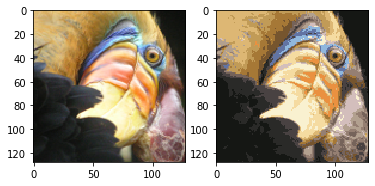

In [41]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(pic)
ax[1].imshow(compressed_pic)
plt.show()

In [42]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="white")

import numpy as np
import pandas as pd
import scipy.io as sio

In [43]:
def get_X(df):
    """
    use concat to add intersect feature to avoid side effect
    not efficient for big dataset though
    """
    ones = pd.DataFrame({'ones': np.ones(len(df))})
    data = pd.concat([ones, df], axis=1)  # column concat
    return data.iloc[:, :-1].as_matrix()  # this return ndarray, not matrix


def get_y(df):
    '''assume the last column is the target'''
    return np.array(df.iloc[:, -1])


def normalize_feature(df):
    """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [44]:
mat = sio.loadmat('data/ex7data1.mat')
X = mat.get('X')

# visualize raw data
print(X.shape)

(50, 2)


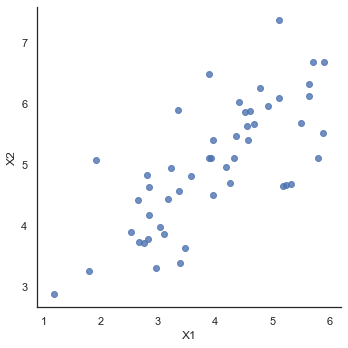

In [45]:
sns.lmplot('X1', 'X2', 
           data=pd.DataFrame(X, columns=['X1', 'X2']),
           fit_reg=False)
plt.show()

In [47]:
# support functions ---------------------------------------
def plot_n_image(X, n):
    """ plot first n images
    n has to be a square number
    """
    pic_size = int(np.sqrt(X.shape[1]))
    grid_size = int(np.sqrt(n))

    first_n_images = X[:n, :]

    fig, ax_array = plt.subplots(nrows=grid_size, ncols=grid_size,
                                    sharey=True, sharex=True, figsize=(8, 8))

    for r in range(grid_size):
        for c in range(grid_size):
            ax_array[r, c].imshow(first_n_images[grid_size * r + c].reshape((pic_size, pic_size)))
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))


# PCA functions ---------------------------------------
def covariance_matrix(X):
    """
    Args:
        X (ndarray) (m, n)
    Return:
        cov_mat (ndarray) (n, n):
            covariance matrix of X
    """
    m = X.shape[0]

    return (X.T @ X) / m


def normalize(X):
    """
        for each column, X-mean / std
    """
    X_copy = X.copy()
    m, n = X_copy.shape

    for col in range(n):
        X_copy[:, col] = (X_copy[:, col] - X_copy[:, col].mean()) / X_copy[:, col].std()

    return X_copy


def pca(X):
    """
    http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html
    Args:
        X ndarray(m, n)
    Returns:
        U ndarray(n, n): principle components
    """
    # 1. normalize data
    X_norm = normalize(X)

    # 2. calculate covariance matrix
    Sigma = covariance_matrix(X_norm)  # (n, n)

    # 3. do singular value decomposition
    # remeber, we feed cov matrix in SVD, since the cov matrix is symmetry
    # left sigular vector and right singular vector is the same, which means
    # U is V, so we could use either one to do dim reduction
    U, S, V = np.linalg.svd(Sigma)  # U: principle components (n, n)

    return U, S, V


def project_data(X, U, k):
    """
    Args:
        U (ndarray) (n, n)
    Return:
        projected X (n dim) at k dim
    """
    m, n = X.shape

    if k > n:
        raise ValueError('k should be lower dimension of n')

    return X @ U[:, :k]


def recover_data(Z, U):
    m, n = Z.shape

    if n >= U.shape[0]:
        raise ValueError('Z dimension is >= U, you should recover from lower dimension to higher')

    return Z @ U[:, :n].T

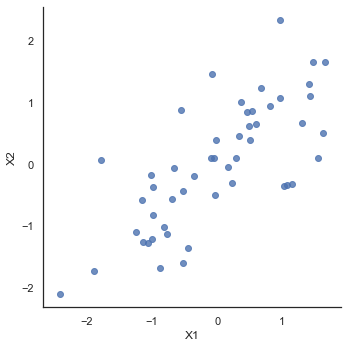

In [48]:
X_norm = normalize(X)

sns.lmplot('X1', 'X2', 
           data=pd.DataFrame(X_norm, columns=['X1', 'X2']),
           fit_reg=False)
plt.show()

In [49]:
Sigma =covariance_matrix(X_norm)  # capital greek Sigma
Sigma  # (n, n)

array([[1.        , 0.73553038],
       [0.73553038, 1.        ]])

In [50]:
U, S, V = pca(X_norm)
U

array([[-0.70710678, -0.70710678],
       [-0.70710678,  0.70710678]])

In [51]:
u1 = U[0]
u1

array([-0.70710678, -0.70710678])

In [52]:
# show top 10 projected data
Z = project_data(X_norm, U, 1)
Z[:10]

array([[ 1.49631261],
       [-0.92218067],
       [ 1.22439232],
       [ 1.64386173],
       [ 1.2732206 ],
       [-0.97681976],
       [ 1.26881187],
       [-2.34148278],
       [-0.02999141],
       [-0.78171789]])

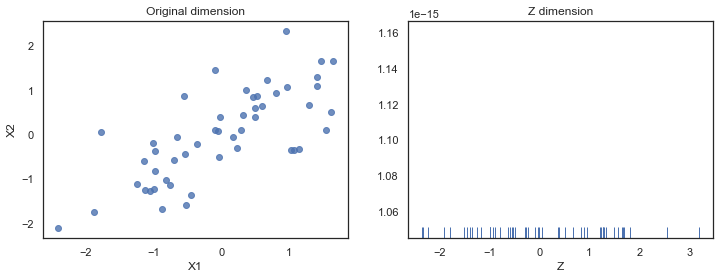

In [53]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

sns.regplot('X1', 'X2', 
           data=pd.DataFrame(X_norm, columns=['X1', 'X2']),
           fit_reg=False,
           ax=ax1)
ax1.set_title('Original dimension')

sns.rugplot(Z, ax=ax2)
ax2.set_xlabel('Z')
ax2.set_title('Z dimension')
plt.show()

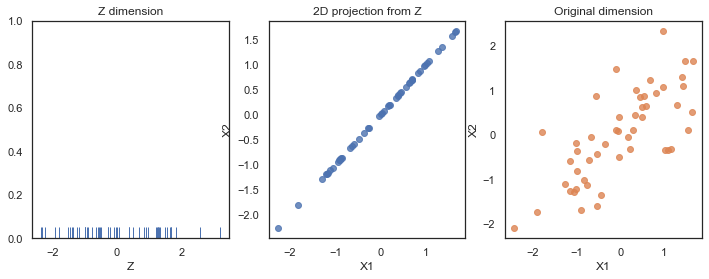

In [54]:
X_recover = recover_data(Z, U)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 4))

sns.rugplot(Z, ax=ax1)
ax1.set_title('Z dimension')
ax1.set_xlabel('Z')

sns.regplot('X1', 'X2', 
           data=pd.DataFrame(X_recover, columns=['X1', 'X2']),
           fit_reg=False,
           ax=ax2)
ax2.set_title("2D projection from Z")

sns.regplot('X1', 'X2', 
           data=pd.DataFrame(X_norm, columns=['X1', 'X2']),
           fit_reg=False,
           ax=ax3)
ax3.set_title('Original dimension')
plt.show()